# Importing Required Libraries

In [1]:
import os
import math
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from tqdm import tqdm
import pickle
import keras
import tensorflow as tf
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, MaxPooling2D, Lambda, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img


2023-07-30 03:06:04.475736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Function To Divide The Dataset 

In [2]:
#function to create a test_set directory

def create_testSet(root_dir, folder_name, split_ratio = 0.15):
    
    if not os.path.exists(root_dir + "/" + folder_name):
        
        os.mkdir(root_dir + "/" + folder_name)
        for folder in os.listdir(root_dir):
            if folder == "training_set":
                for categories in os.listdir(os.path.join(root_dir, folder)):
                    os.makedirs(root_dir + "/" + folder_name + "/" + categories)
                    for images in np.random.choice(a = os.listdir(os.path.join(root_dir, folder, categories)), 
                                                  size = math.floor(split_ratio * len(os.listdir(os.path.join(root_dir, folder, categories)))),
                                                  replace = False
                                                  ):
                        image_set = os.path.join(root_dir, folder, categories, images)
                        destination_folder = os.path.join(root_dir, folder_name, categories)

                        shutil.copy(image_set, destination_folder)
                        os.remove(image_set)
            else:
                pass
        print("Test folder successfully created")    
    else:
        print("Directory already exist")   

     

In [37]:
#creating the test_set folder from the dataset

root_dir = "/Users/rahmonolusegunadeniji/Documents/Project/Cervical_Cancer"
folder_name = "test_set"

create_testSet(root_dir, folder_name)

Test folder successfully created


In [4]:
root_dir = "/Users/rahmonolusegunadeniji/Documents/Project/Cervical_Cancer"
folder_name = "test_set"

In [5]:
# counting the number of files in each class with respect to the training set

class_names = []
number_of_images_in_classes = []

for  category in os.listdir(os.path.join(root_dir, "training_set")):
    class_names.append(category)
    number_of_images_in_classes.append(len(os.listdir(os.path.join(root_dir, "training_set",category))))
    print("The number of images present in {} is: {}".format(category, len(os.listdir(os.path.join(root_dir, "training_set",category)))))



The number of images present in Metaplastic is: 4250
The number of images present in Superficial_Intermediate is: 4250
The number of images present in Dyskeratotic is: 4250
The number of images present in Koilocytotic is: 4250
The number of images present in Parabasal is: 4250


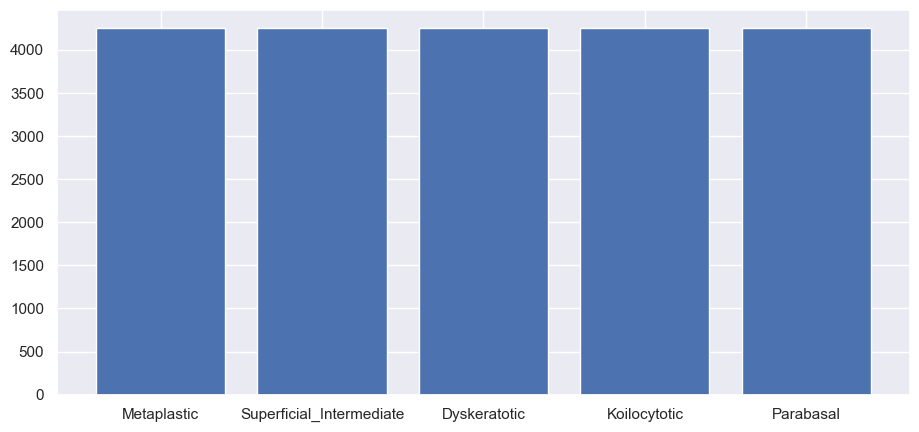

In [6]:
#Visualizing the number of classes present in the training dataset

"This shows we have a balanced dataset"

fig = plt.figure(figsize=(11,5))

plt.bar(range(len(class_names)), number_of_images_in_classes, tick_label = class_names)

plt.show()

In [7]:
# counting the number of files in each class with respect to the testing set

class_names = []
number_of_images_in_classes = []

for  category in os.listdir(os.path.join(root_dir, "test_set")):
    class_names.append(category)
    number_of_images_in_classes.append(len(os.listdir(os.path.join(root_dir, "test_set",category))))
    print("The number of images present in {} is: {}".format(category, len(os.listdir(os.path.join(root_dir, "test_set",category)))))



The number of images present in Metaplastic is: 750
The number of images present in Superficial_Intermediate is: 750
The number of images present in Dyskeratotic is: 750
The number of images present in Koilocytotic is: 750
The number of images present in Parabasal is: 750


<BarContainer object of 5 artists>

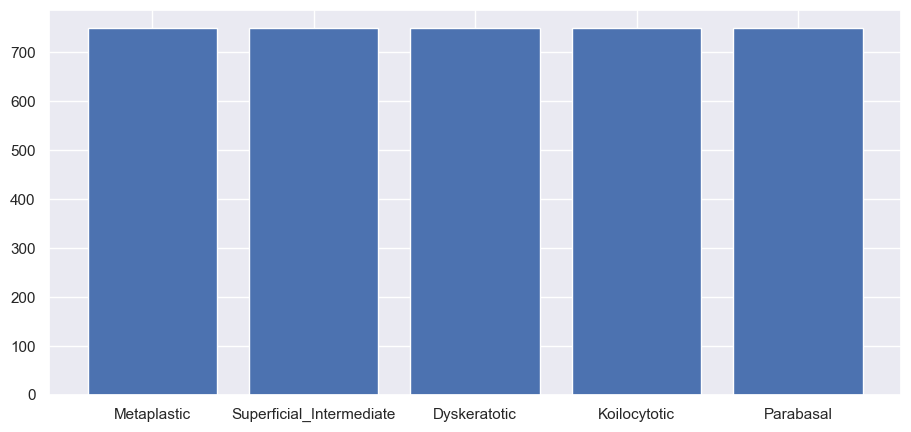

In [8]:
#Visualizing the number of classes present in the test dataset

"This shows we have a balanced dataset"

fig = plt.figure(figsize=(11,5))

plt.bar(range(len(class_names)), number_of_images_in_classes, tick_label = class_names)


# Converting The File Names Into a Dictionary

In [9]:
class_label = []
class_code = []
file_name = []
file_name_with_directory = []

counter = 0

for  category in os.listdir(os.path.join(root_dir, "training_set")):
    images = os.listdir(os.path.join(root_dir, "training_set",category))
    
    
    for image in images:
        file_name.append(image)
        class_code.append(counter)
        class_label.append(category)
        file_name_with_directory.append(os.path.join(root_dir, "training_set", category, image))

    counter += 1
    
training_img_info = pd.DataFrame(
                                  {
                                  "file_name": file_name,
                                  "class_label": class_label, 
                                  "class_code": class_code,
                                  "file_name_with_directory": file_name_with_directory
                                  }
                                )


In [10]:
training_img_info.head()

,file_name,class_label,class_code,file_name_with_directory
0,cervix_mep_3132.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
1,cervix_mep_4885.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
2,cervix_mep_1043.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
3,cervix_mep_3898.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
4,cervix_mep_3640.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...


In [11]:
training_img_info.shape

(21250, 4)

In [12]:
training_img_info.class_label.unique()

array(['Metaplastic', 'Superficial_Intermediate', 'Dyskeratotic',
       'Koilocytotic', 'Parabasal'], dtype=object)

In [13]:
training_img_info.class_code.unique()

array([0, 1, 2, 3, 4])

# Shuffling The Dataframe

In [20]:
shuffled_training_img_info = training_img_info.sample(frac = 1).reset_index(drop = True)

In [21]:
np.random.seed(317)

In [22]:
shuffled_training_img_info.head(30)

,file_name,class_label,class_code,file_name_with_directory
0,cervix_koc_1467.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...
1,cervix_koc_0169.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...
2,cervix_sfi_3933.jpg,Superficial_Intermediate,1,/Users/rahmonolusegunadeniji/Documents/Project...
3,cervix_pab_1067.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
4,cervix_mep_2888.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
5,cervix_dyk_2485.jpg,Dyskeratotic,2,/Users/rahmonolusegunadeniji/Documents/Project...
6,cervix_mep_2903.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
7,cervix_mep_4074.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
8,cervix_dyk_0911.jpg,Dyskeratotic,2,/Users/rahmonolusegunadeniji/Documents/Project...
9,cervix_pab_4408.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...


In [24]:
#shuffled_training_img_info.to_csv("/Users/rahmonolusegunadeniji/Documents/Project/Cervical_Cancer/saved_training_id_info.csv", index = False)

In [25]:
class_label = []
class_code = []
file_name = []
file_name_with_directory = []

counter = 0

for  category in os.listdir(os.path.join(root_dir, "test_set")):
    images = os.listdir(os.path.join(root_dir, "test_set",category))
    
    
    for image in images:
        file_name.append(image)
        class_code.append(counter)
        class_label.append(category)
        file_name_with_directory.append(os.path.join(root_dir, "test_set", category, image))

    counter += 1
    
test_img_info = pd.DataFrame(
                                  {
                                  "file_name": file_name,
                                  "class_label": class_label, 
                                  "class_code": class_code,
                                  "file_name_with_directory": file_name_with_directory
                                  }
                                )


In [26]:
test_img_info

,file_name,class_label,class_code,file_name_with_directory
0,cervix_mep_1725.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
1,cervix_mep_3654.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
2,cervix_mep_0407.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
3,cervix_mep_2210.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
4,cervix_mep_0361.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
...,...,...,...,...
3745,cervix_pab_0392.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
3746,cervix_pab_1098.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
3747,cervix_pab_3894.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
3748,cervix_pab_3664.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...


In [27]:
shuffled_test_img_info = test_img_info.sample(frac=1).reset_index(drop = True)

In [28]:
shuffled_test_img_info

,file_name,class_label,class_code,file_name_with_directory
0,cervix_dyk_0275.jpg,Dyskeratotic,2,/Users/rahmonolusegunadeniji/Documents/Project...
1,cervix_mep_3339.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
2,cervix_pab_3583.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
3,cervix_koc_2077.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...
4,cervix_pab_2875.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
...,...,...,...,...
3745,cervix_mep_0895.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
3746,cervix_mep_1418.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
3747,cervix_mep_2388.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
3748,cervix_koc_3107.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...


In [29]:
#shuffled_test_img_info.to_csv("/Users/rahmonolusegunadeniji/Documents/Project/Cervical_Cancer/saved_test_id_info.csv", index=False)

In [30]:
saved_training_img_info = pd.read_csv("/Users/rahmonolusegunadeniji/Documents/Project/Cervical_Cancer/saved_training_id_info.csv")

In [31]:
saved_training_img_info.head()

,file_name,class_label,class_code,file_name_with_directory
0,cervix_koc_1467.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...
1,cervix_koc_0169.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...
2,cervix_sfi_3933.jpg,Superficial_Intermediate,1,/Users/rahmonolusegunadeniji/Documents/Project...
3,cervix_pab_1067.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
4,cervix_mep_2888.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...


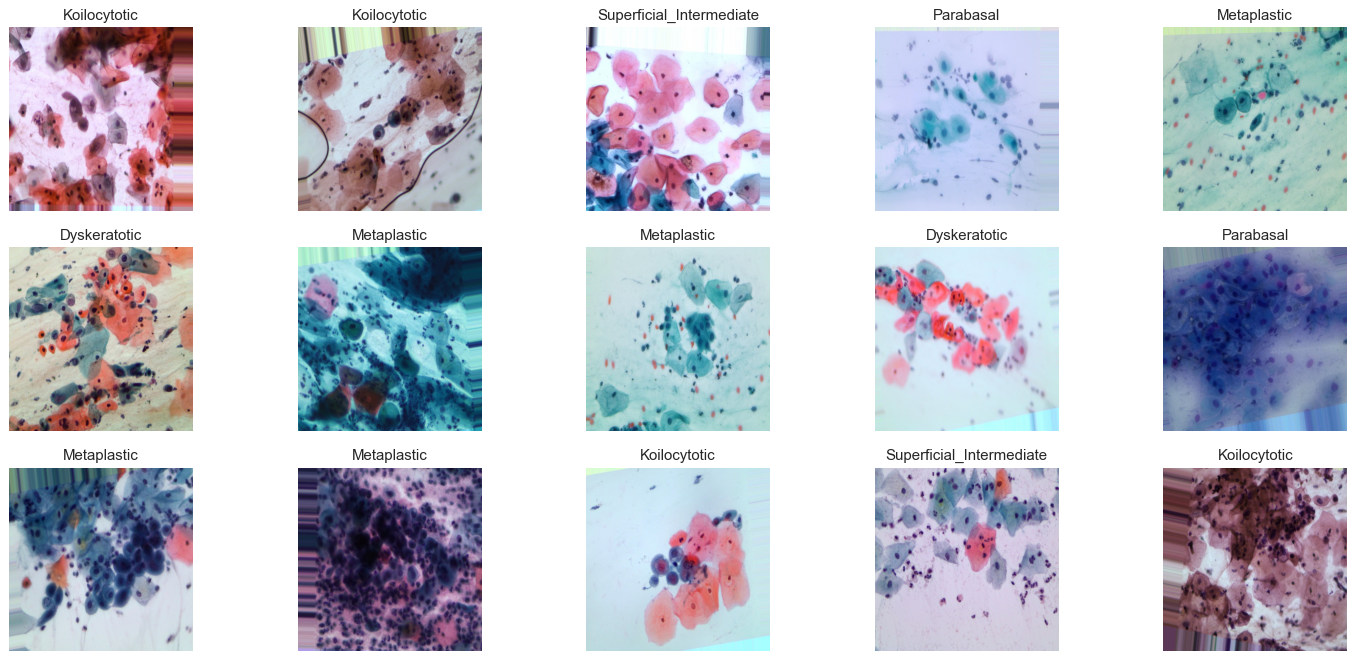

In [32]:
#Visualizing samples of the images

plt.figure(figsize=(20,9), dpi = 90)

for i in range(len(shuffled_training_img_info.iloc[:15])):
    plt.subplot(3, 5, i+1)
    plt.imshow(plt.imread(saved_training_img_info["file_name_with_directory"].iloc[i]))
    plt.title(shuffled_training_img_info["class_label"].iloc[i])
    plt.axis("off")

# Encoding The Class Label

In [33]:
y = to_categorical(saved_training_img_info.class_code)

In [34]:
y[:20]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

# Feature Extraction Design

In [2]:
from keras.applications.nasnet import NASNetLarge,preprocess_input as nasnet_preprocess
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as Iresnet_preprocess
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess

from keras.layers import concatenate

In [3]:
#definining the input shape

input_shape = (512, 512, 3)

input_layer = Input(shape = input_shape)

In [4]:
#Feature Extractor 1

preprocesor_nasnet = Lambda(nasnet_preprocess)(input_layer)
Nasnet = NASNetLarge(
    weights = "imagenet",
    include_top = False,
    input_shape = input_shape,
    pooling = "avg"
    )(preprocesor_nasnet)


#Feature Extractor 2

preprocesor_resnet = Lambda(Iresnet_preprocess)(input_layer)
InceptionResnet = InceptionResNetV2(
    weights = "imagenet",
    include_top = False,
    input_shape = input_shape,
    pooling = "avg"
    )(preprocesor_resnet)


#Feature Extractor 3

preprocesor_inception = Lambda(inception_preprocess)(input_layer)
Inception_v3 = InceptionV3(
    weights = "imagenet",
    include_top = False,
    input_shape = input_shape,
    pooling = "avg"
    )(preprocesor_inception)


#Feature Extractor 4

preprocesor_xception = Lambda(xception_preprocess)(input_layer)
Xception = Xception(
    weights = "imagenet",
    include_top = False,
    input_shape = input_shape,
    pooling = "avg"
    )(preprocesor_xception)

In [5]:
#merging the feature extractors together

merged_extractors = concatenate([Nasnet, InceptionResnet, Inception_v3, Xception])

merged_model = Model(inputs = input_layer, outputs = merged_extractors)

In [51]:
merged_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 lambda_5 (Lambda)           (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_6 (Lambda)           (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_7 (Lambda)           (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                              

In [6]:
merged_model.save("/Users/rahmonolusegunadeniji/Documents/Project/image_models/merged_model2.h5")

/Users/rahmonolusegunadeniji/Documents/Project/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
feature_extractor_file_obj = open("/Users/rahmonolusegunadeniji/Documents/Project/image_models/feature_extractor.pkl", "wb")

pickle.dump(merged_model, feature_extractor_file_obj)

feature_extractor_file_obj.close()

In [56]:
#ploting the feature extractors

from keras.utils import plot_model

plot_model(merged_model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [57]:
#checking the model shape

merged_model.output.shape

TensorShape([None, 9664])

In [58]:
len(merged_model.trainable_weights)

1846

# Feature Extraction Implementation

In [71]:
def feature_extraction(data_frame):

    image_size = (512, 512, 3)
    
    data_size = len(data_frame)

    batch_size = 16

    feature_extract = np.zeros([data_size, 9664], dtype = np.uint8)

    Datagen = ImageDataGenerator()

    Generator = Datagen.flow_from_dataframe(
        data_frame,
        x_col = "file_name_with_directory",
        class_mode = None,
        batch_size = batch_size,
        shuffle = False,
        target_size = (image_size[:2]),
        color_mode = "rgb"
    )

    counter = 0

    for batch in tqdm(Generator):
        batch = merged_model.predict(batch)
        feature_extract[counter * batch_size: (counter + 1)* batch_size] = batch
        counter += 0

        if counter * batch_size >= data_size:
            break
    
    return feature_extract


In [70]:
extracted_features = feature_extraction(saved_training_img_info)

Found 21250 validated image filenames.


  0%|          | 0/1329 [00:34<?, ?it/s]


KeyboardInterrupt: 

In [72]:
test_df = pd.read_csv("Cervical_Cancer/saved_test_id_info.csv")

In [73]:
test_df1 = test_df.copy()

In [74]:
test_df1.head()

,file_name,class_label,class_code,file_name_with_directory
0,cervix_dyk_0275.jpg,Dyskeratotic,2,/Users/rahmonolusegunadeniji/Documents/Project...
1,cervix_mep_3339.jpg,Metaplastic,0,/Users/rahmonolusegunadeniji/Documents/Project...
2,cervix_pab_3583.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...
3,cervix_koc_2077.jpg,Koilocytotic,3,/Users/rahmonolusegunadeniji/Documents/Project...
4,cervix_pab_2875.jpg,Parabasal,4,/Users/rahmonolusegunadeniji/Documents/Project...


In [76]:
test_df1["class_code"].unique()

array([2, 0, 4, 3, 1])

In [77]:
test_df1["class_label"].unique()

array(['Dyskeratotic', 'Metaplastic', 'Parabasal', 'Koilocytotic',
       'Superficial_Intermediate'], dtype=object)

In [83]:
saved_training_img_info["class_label"].unique()

array(['Koilocytotic', 'Superficial_Intermediate', 'Parabasal',
       'Metaplastic', 'Dyskeratotic'], dtype=object)

In [84]:
saved_training_img_info["class_code"].unique()

array([3, 1, 4, 0, 2])

In [82]:
d = {'Dyskeratotic': 2, 'Metaplastic':0, 'Parabasal':4, 'Koilocytotic':3,
       'Superficial_Intermediate': 1}

In [ ]:
for 